              name  gp   min  pts  fgm  fga    fg  3p_made  3pa    3p  ...  \
0   Brandon Ingram  36  27.4  7.4  2.6  7.6  34.7      0.5  2.1  25.0  ...   
1  Andrew Harrison  35  26.9  7.2  2.0  6.7  29.6      0.7  2.8  23.5  ...   
2   JaKarr Sampson  74  15.3  5.2  2.0  4.7  42.2      0.4  1.7  24.4  ...   
3      Malik Sealy  58  11.6  5.7  2.3  5.5  42.6      0.1  0.5  22.6  ...   
4      Matt Geiger  48  11.5  4.5  1.6  3.0  52.4      0.0  0.1   0.0  ...   

   fta    ft  oreb  dreb  reb  ast  stl  blk  tov  target_5yrs  
0  2.3  69.9   0.7   3.4  4.1  1.9  0.4  0.4  1.3            0  
1  3.4  76.5   0.5   2.0  2.4  3.7  1.1  0.5  1.6            0  
2  1.3  67.0   0.5   1.7  2.2  1.0  0.5  0.3  1.0            0  
3  1.3  68.9   1.0   0.9  1.9  0.8  0.6  0.1  1.0            1  
4  1.9  67.4   1.0   1.5  2.5  0.3  0.3  0.4  0.8            1  

[5 rows x 21 columns]


(array([  5.,  50., 189., 398., 420., 194.,  67.,  13.,   3.,   1.]),
 array([23.8 , 28.79, 33.78, 38.77, 43.76, 48.75, 53.74, 58.73, 63.72,
        68.71, 73.7 ]),
 <BarContainer object of 10 artists>)

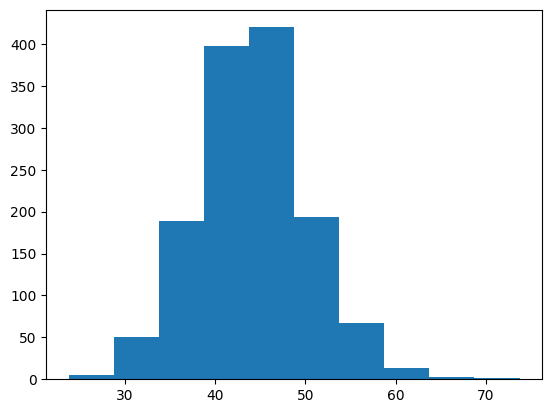

In [2]:
#imports
import pandas as pd
import pymc as pm
from scipy import stats
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

##PART 1 - Dataset
#Dataset can be found here: https://www.kaggle.com/datasets/yakhyojon/national-basketball-association-nba
url = 'https://raw.githubusercontent.com/juliacmurray/STA365/main/STA365%20nba-players.csv'
df = pd.read_csv(url, index_col=0)

norm_data = df.filter(items=['fg'])
unnorm_data = df.filter(items=['fga'])
#Run two histograms and make sure I'm right
plt.hist(norm_data) #looks normal enough

(array([194., 422., 283., 174.,  91.,  70.,  48.,  31.,  19.,   8.]),
 array([ 0.8,  2.7,  4.6,  6.5,  8.4, 10.3, 12.2, 14.1, 16. , 17.9, 19.8]),
 <BarContainer object of 10 artists>)

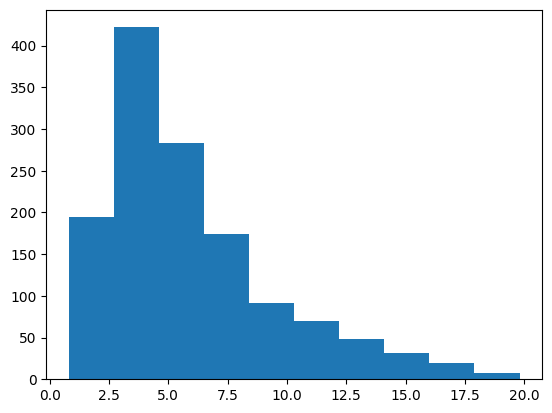

In [3]:
plt.hist(unnorm_data)#looks pretty unnormal

In [ ]:
##PART 2 - Posterior Analysis on the Normal Looking Data
#Data = percentage of made field goals per game

theta_0 = 40 #avg of theta prior
tau = 1/5 #precision for theta prior
alpha,beta = 2,1/2 #hyperparameters for phi

#Building the normal-gamma model

x = norm_data
normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=theta_0, sigma=tau**0.5)
    phi = pm.Gamma("phi", alpha=alpha, beta=beta)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=x)

with normal_gamma_toy_model:
    normgam_HMC = pm.sample()


Normal-Gamma HMC Split-Rhats {'theta': 1.0017, 'phi': 1.0013} | 

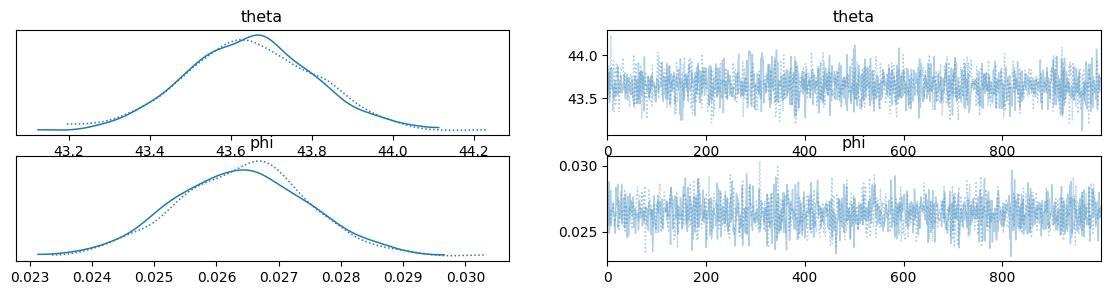

In [ ]:
#Traceplots and Rhat
fig,ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(normgam_HMC, axes=ax[:2,:2])
print("Normal-Gamma HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(normgam_HMC).items()}, end=' | ')



array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

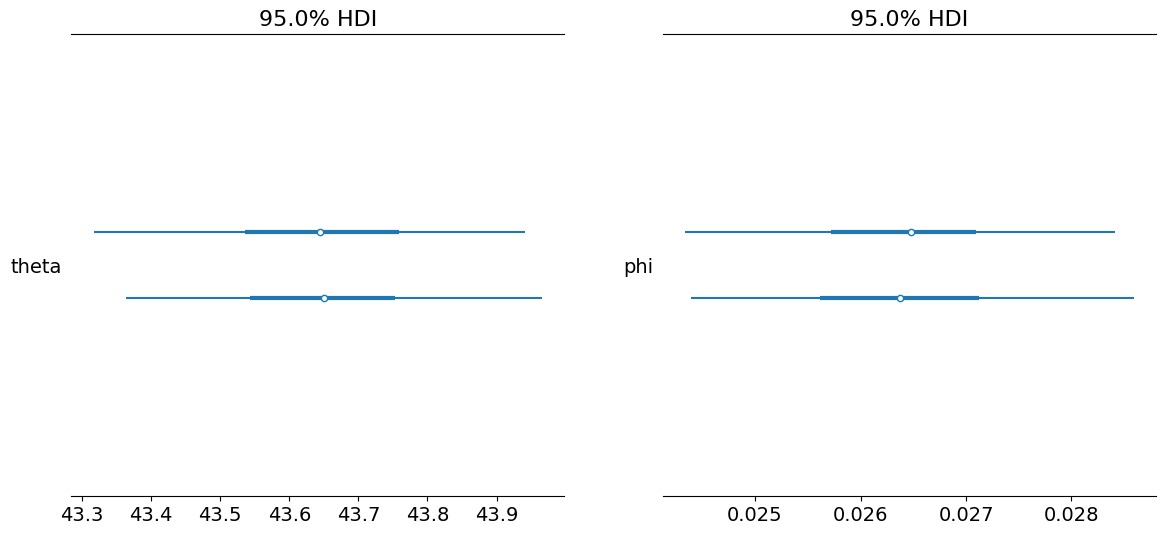

In [ ]:
#CIs
fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(normgam_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(normgam_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1])

In [ ]:
##PARTS 3 & 4- Posterior Analysis on non-normal looking data
#Data = number of field goals attempted

#Building the unnormal model
#I think my likelihood looks like a right skewed chi-squared distribution (nu=3)
#But the support is larger: 0 to 20
nu=3
utheta_0 = nu #avg of theta prior
utau = 1 #precision for theta prior
alpha,beta = 2,1/2 #hyperparameters for phi

x = unnorm_data
unnormal_toy_model = pm.Model()
with unnormal_toy_model:
    theta = pm.Normal("theta", mu=utheta_0, sigma=utau**0.5)
    phi = pm.Gamma("phi", alpha=alpha, beta=beta)
    un_obs = pm.ChiSquared("likelihood", nu=nu, observed=unnorm_data)

with unnormal_toy_model:
    unnorm_HMC = pm.sample()


Unnormal HMC Split-Rhats {'theta': 1.0004, 'phi': 0.9999} | 

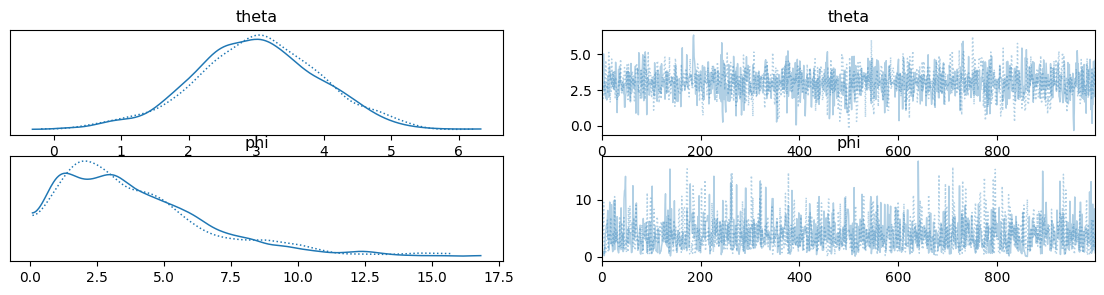

In [ ]:
#Traceplots and Rhat
fig,ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(unnorm_HMC, axes=ax[:2,:2])
print("Unnormal HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(unnorm_HMC).items()}, end=' | ')


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

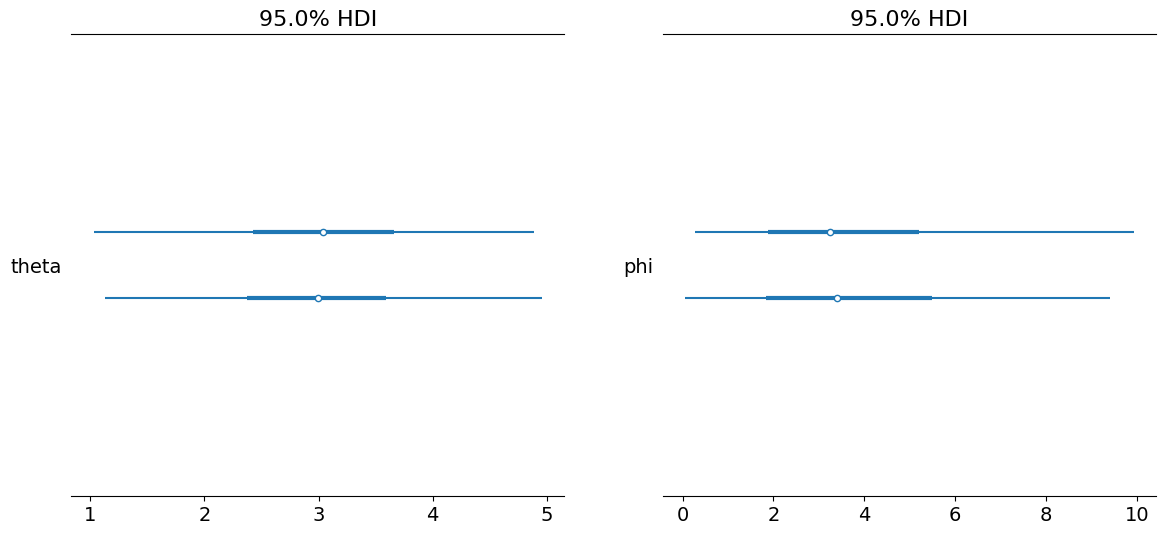

In [ ]:
#CIs
fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(unnorm_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(unnorm_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1])